In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm import tqdm

from lyapunov import EnergyModel, random_uniform, RandomWalkParams

c:\Users\shuir\scoop\apps\miniconda3\current\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
class GradientNormHistoryCallback:
    
    def __init__(self, model, log_steps):
        self.model = model
        self.log_steps = tf.constant(int(log_steps), dtype='int32')
        self.history = [[] for _ in model.params]

    def __call__(self, model, step, batch, grads):
        if tf.greater(step % self.log_steps, 0):
            return

        for history, grad in zip(self.history, grads):
            grad_norm = tf.reduce_mean(tf.abs(grad))
            history.append(grad_norm)

In [68]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


def filter_img(image, label):
    return image

def normalize_img(image):
    """Normalizes images: `uint8` -> `float32`."""
    return 2 * tf.cast(image, tf.float32) / 255 - 1

def reshape_img(image):
    return tf.reshape(image, [28*28])

dataset = (ds_train
    .map(filter_img, num_parallel_calls=tf.data.AUTOTUNE)
    .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    .map(reshape_img, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(ds_info.splits['train'].num_examples)
    .repeat(5)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)

In [69]:
network = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, tf.nn.relu),
    tf.keras.layers.Dense(1, use_bias=False),
])
network.build([None, 28*28])
model = EnergyModel(network, random_uniform([128, 28*28]))

optimizer = tf.keras.optimizers.RMSprop(clipvalue=1e-1)
params = RandomWalkParams(2e-0, 1e-1, 1e-2)
callbacks = [GradientNormHistoryCallback(model, log_steps=100)]

train_step = model.get_optimize_fn(optimizer, params, callbacks=callbacks)
train_step = tf.function(train_step)

In [70]:
for batch in tqdm(dataset):
    train_step(batch)

100%|██████████| 2344/2344 [03:22<00:00, 11.55it/s]


In [71]:
callbacks[0].history[0]

[<tf.Tensor 'Mean_2:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_2:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_2:0' shape=() dtype=float32>]

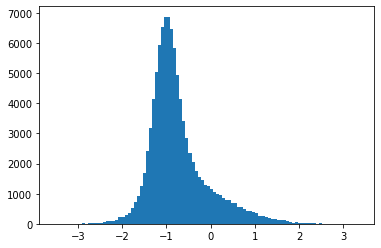

In [72]:
plt.hist(model.fantasy_particles.numpy().reshape([-1]), bins=100)
plt.show()

In [73]:
test_X = list(dataset)[1]

In [95]:
relax_params = RandomWalkParams(1e+1, 1e-1, 0.0)
noised_X = test_X + 0.5 * tf.random.truncated_normal(test_X.shape)
relaxed_X = model(noised_X, relax_params)

In [96]:
network(noised_X) - network(relaxed_X)

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[18.179373],
       [19.03385 ],
       [18.58025 ],
       [18.2462  ],
       [17.492968],
       [16.791695],
       [19.185629],
       [19.453144],
       [18.015432],
       [18.682909],
       [17.254786],
       [19.77463 ],
       [18.547848],
       [20.234503],
       [17.301382],
       [19.285563],
       [17.337465],
       [19.032934],
       [18.521706],
       [18.875608],
       [19.14315 ],
       [19.017414],
       [18.880901],
       [17.91922 ],
       [19.498207],
       [18.110188],
       [16.33871 ],
       [18.112417],
       [16.164444],
       [18.99847 ],
       [20.594086],
       [20.997564],
       [18.336819],
       [18.717587],
       [18.94093 ],
       [19.272722],
       [18.523407],
       [19.237461],
       [19.847736],
       [19.046501],
       [21.002596],
       [19.295359],
       [18.91787 ],
       [19.746918],
       [18.941696],
       [18.6704  ],
       [18.206282],
       [19

In [97]:
network(test_X) - network(relaxed_X)

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[ 7.4164305],
       [ 9.084175 ],
       [10.213295 ],
       [ 8.758934 ],
       [ 7.611597 ],
       [ 6.5661993],
       [10.839371 ],
       [10.000186 ],
       [ 8.546368 ],
       [ 9.357105 ],
       [ 9.071129 ],
       [11.110275 ],
       [ 8.775575 ],
       [10.873953 ],
       [ 8.774719 ],
       [10.354122 ],
       [ 8.260339 ],
       [ 9.309212 ],
       [ 9.083656 ],
       [ 8.834261 ],
       [ 9.168551 ],
       [10.276864 ],
       [10.063115 ],
       [ 8.650333 ],
       [10.6545515],
       [ 8.006178 ],
       [ 8.194656 ],
       [ 8.593708 ],
       [ 6.8151054],
       [ 9.131624 ],
       [ 9.487698 ],
       [11.4836645],
       [ 9.672552 ],
       [10.536322 ],
       [10.555324 ],
       [ 9.927595 ],
       [ 9.763375 ],
       [ 9.585643 ],
       [10.858026 ],
       [ 9.690077 ],
       [11.5439   ],
       [10.156673 ],
       [10.178165 ],
       [10.209446 ],
       [10.4354925],
     

In [77]:
def display_img(x):
    x = x.numpy().reshape([28, 28])
    plt.imshow(x)

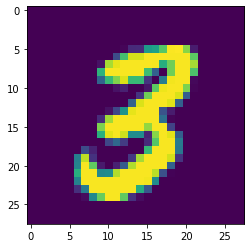

In [98]:
i = 0
display_img(test_X[i, :])

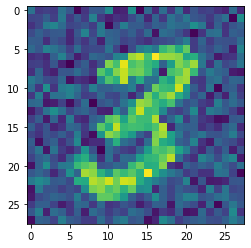

In [99]:
display_img(noised_X[i, :])

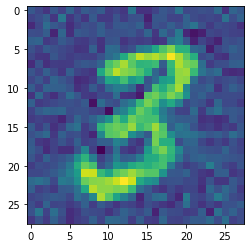

In [100]:
display_img(relaxed_X[i, :])